# Simple Walk 2D continuous more dynamically

base environment on https://github.com/nicknochnack/ReinforcementLearningCourse/blob/main/Project%203%20-%20Custom%20Environment.ipynb

continuous state space environment

action space: BOX in two directions from -1 to 1

state space: box with shape(2,1)?

goal reached when distance closer than 1





## 1. Import Dependencies

In [12]:
import gym 
from gym import Env
from gym.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 
import numpy as np
import random
import os
import math
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.evaluation import evaluate_policy

import matplotlib.pyplot as plt

# logging
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)


In [9]:
class SimpleWalk2Dcont(Env):
    """simple walk environment in 2D with a continuous action and state space"""
    def __init__(self):
        """Initialize the environment
        Big square as the environment and sub squares as the goal"""
        
        # set the dimensions of the environment
        # environment is square, therefore x and y are the same
        self.x_min = 0.0
        self.x_max = 20.0
        self.width = self.x_max - self.x_min
        
        
        # set maximum number of steps to reach the goal
        # if the maximum number of steps is reached, the episode is over
        # maximum is max steps to cross the field
        self.max_steps = int(math.ceil(self.x_max - self.x_min))
        
        # set goal boarder
        self.goal_boarder = 3.0
        
        # ensure that the goal can not walk out of the environment
        self.goal_max_speed =  self.goal_boarder / self.max_steps * 0.9
        
        self.viable_goal_distance = 0.5
        
        
        # set spaces
        self.action_space = Box(low=-1.0, high=1.0, shape=(2, )) # x and y change of position
        self.observation_space = Box(low=self.x_min, high=self.x_max, shape=(4, )) # x,y position, x,y goal
        
        # safe past states in an array, safe x and y positions
        self.state = np.ndarray(shape=(4,), dtype=np.float32)
        
        
    def __out_of_bounds(self):
        """check if the current state is out of bounds"""
        position = self.state[0:2]
        for element in position:
            if not (self.x_min <= element <= self.x_max):
                
                return True
            else:
                return False
            
    def __append_state(self):
        self.state_array[0].append(self.state[0])
        self.state_array[1].append(self.state[1])
        
    def __distance_to_goal(self):
        distance_to_goal = np.linalg.norm(self.state[0:2] - self.state[2:4])
        return distance_to_goal     
        
    
    def step(self, action):
        previous_state = self.state
        # update position
        self.state[0] += action[0] # update x
        self.state[1] += action[1] # update y
        self.__append_state()
        new_state = self.state
        self.steps_taken += 1
        distance_to_goal = self.__distance_to_goal()
    
        if self.steps_taken >= self.max_steps:
            # maximum number of steps reached
            logging.debug("maximum number of steps reached")
            reward = -100.0
            done = True
        elif self.__out_of_bounds():
            # went out of bounds
            logging.debug("out of bounds")
            reward = -100.0
            done = True
        elif distance_to_goal < self.viable_goal_distance:
            # reached goal
            reward = 1000.0
            logging.debug("reached goal")
            done = True
        elif False: # self.distance_to_goal > distance_to_goal:
            # got closer
            logging.debug("got closer")
            reward = (self.distance_to_goal - distance_to_goal) * 20
            done = False
        else:
            
            movement = self.distance_to_goal - distance_to_goal
            logging.debug("movement: {}".format(movement))
            reward = movement * 50
            done = False
        
        # update distance to goal
        self.distance_to_goal = distance_to_goal
        info = {'distance_to_goal': self.distance_to_goal, 
                'steps_taken': self.steps_taken,
                'previous_state': previous_state,
                'new_state': new_state}
        
        return self.state, reward, done, info
    
    def reset(self):
        """reset and initialize the environment"""
        
        # set x and y of position
        self.state[0:2] = np.random.uniform(low=self.x_min, high=self.x_max, size=(2,))
        
        # set goal to a random value, shrinked from entire environment size
        self.state[2:4] = np.random.uniform(
            low = self.x_min + self.width * self.shrink_factor, 
            high = self.x_max - self.width * self.shrink_factor, 
            size=(2,)
            )
        
        self.state_array = [[], []] # x, y
        self.__append_state()
        self.steps_taken = 0
        self.distance_to_goal = self.__distance_to_goal()
        return self.state
    
    def render(self):
        
        # logging.debug("visited states: ", self.state_array)
        logging.debug("x: {}".format(self.state_array[0]))
        logging.debug("y: {}".format(self.state_array[1]))
        goal = self.state[2:4]
        logging.debug("goal: {}".format(goal))
        
        
        # plot
        fig, ax = plt.subplots()

        # plot the visited states
        ax.plot(self.state_array[0], self.state_array[1], linewidth=2.0)
        
        # plot the goal
        ax.plot(goal[0], goal[1], 'ro')
        circle1 = plt.Circle((goal[0], goal[1]), 1, color='r', fill=False)
        ax.add_patch(circle1)
        ax.set(
            xlim=(self.x_min, self.x_max), #xticks=np.arange(1, 8),
            ylim=(self.x_min, self.x_max), #yticks=np.arange(1, 8))
            )
        plt.show()
        
    

    
env = SimpleWalk2Dcont()

print(env.action_space.sample())
print(env.observation_space.sample())

[0.14235938 0.1356492 ]
[2.8168418 5.3605094 8.181946  7.4034486]


## Check Environment

### random walk

DEBUG:root:state: [3.1230597 6.065795  9.315923  9.320174 ]
DEBUG:root:movement: -0.5582146644592285
DEBUG:root:Steps taken: 1
DEBUG:root:distance to goal: 7.554108619689941
DEBUG:root:movement: -0.3966197967529297
DEBUG:root:Steps taken: 2
DEBUG:root:distance to goal: 7.950728416442871
DEBUG:root:movement: -0.9313058853149414
DEBUG:root:Steps taken: 3
DEBUG:root:distance to goal: 8.882034301757812
DEBUG:root:movement: 0.6909732818603516
DEBUG:root:Steps taken: 4
DEBUG:root:distance to goal: 8.191061019897461
DEBUG:root:movement: -0.14835071563720703
DEBUG:root:Steps taken: 5
DEBUG:root:distance to goal: 8.339411735534668
DEBUG:root:movement: -0.1822052001953125
DEBUG:root:Steps taken: 6
DEBUG:root:distance to goal: 8.52161693572998
DEBUG:root:movement: 1.1268696784973145
DEBUG:root:Steps taken: 7
DEBUG:root:distance to goal: 7.394747257232666
DEBUG:root:movement: 1.011967658996582
DEBUG:root:Steps taken: 8
DEBUG:root:distance to goal: 6.382779598236084
DEBUG:root:movement: 0.394023895

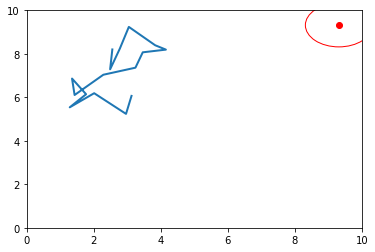

In [11]:
env = SimpleWalk2Dcont()
episodes = 1
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    logging.debug('state: {}'.format(state))
    
    while not done:
        # env.render()
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        logging.debug('Steps taken: {}'.format(info['steps_taken']))
        logging.debug('distance to goal: {}'.format(info['distance_to_goal']))
        score+=reward
    logging.info('Episode:{}'.format(episode)) #, score))
    logging.info('Score: {}'.format(score))
    env.render()
env.close()

### env_checker

In [5]:
from stable_baselines3.common import env_checker
env_checker.check_env(env)

DEBUG:root:movement: -1.139786958694458


AssertionError: The observation returned by the `step()` method does not match the given observation space

## Callback

In [6]:
# create callback fun

import os
from stable_baselines3.common.callbacks import BaseCallback

class TrainAndLoggingCallback(BaseCallback):
    
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok = True)
            
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
            
        return True

env_name = 'Walk2Dcont'

CHECKPOINT_DIR = './train/train_' + env_name
LOG_DIR = './train/log_' + env_name

callback = TrainAndLoggingCallback(check_freq=10_000, save_path=CHECKPOINT_DIR)

## Train

In [7]:
log_path = os.path.join('Training', 'Logs')

In [8]:
model = PPO(
    "MlpPolicy", 
    env, 
    verbose=1, 
    tensorboard_log=log_path,
    learning_rate=0.001,
    n_steps =256
    )
logger.setLevel(logging.INFO)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [9]:
model.learn(
    total_timesteps=15_000, 
    callback = callback
    )

Logging to Training/Logs/PPO_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.8     |
|    ep_rew_mean     | -136     |
| time/              |          |
|    fps             | 290      |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 256      |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 2.6        |
| time/                   |            |
|    fps                  | 438        |
|    iterations           | 2          |
|    time_elapsed         | 1          |
|    total_timesteps      | 512        |
| train/                  |            |
|    approx_kl            | 0.02869892 |
|    clip_fraction        | 0.19       |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.82      |
|    explained_variance   | 6.47e-05   |
|    learning_

In [10]:
model.save('PPO')
logger.setLevel(logging.DEBUG)

## Test Model

DEBUG:root:movement: 1.407277879980552
DEBUG:root:movement: 1.4000209906445265
DEBUG:root:movement: 1.3696565623075492
DEBUG:root:reached goal
--- Logging error ---
Traceback (most recent call last):
  File "/home/luttkule/anaconda3/envs/rl-test/lib/python3.9/logging/__init__.py", line 1083, in emit
    msg = self.format(record)
  File "/home/luttkule/anaconda3/envs/rl-test/lib/python3.9/logging/__init__.py", line 927, in format
    return fmt.format(record)
  File "/home/luttkule/anaconda3/envs/rl-test/lib/python3.9/logging/__init__.py", line 663, in format
    record.message = record.getMessage()
  File "/home/luttkule/anaconda3/envs/rl-test/lib/python3.9/logging/__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/home/luttkule/anaconda3/envs/rl-test/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/luttkule/anaconda3/en

info {'distance_to_goal': 0.49960882309909, 'steps_taken': 4, 'previous_state': array([4.05855305, 8.50832656, 4.27110627, 8.05618709]), 'new_state': array([4.05855305, 8.50832656, 4.27110627, 8.05618709])}


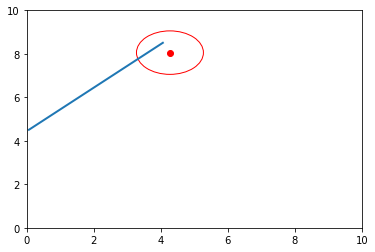

In [11]:
# test prediction
env = SimpleWalk2Dcont()
env.reset()

while True:
    action, _states = model.predict(env.state)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break
env.render()


DEBUG:root:movement: 0.8879499060319205
DEBUG:root:movement: 0.9873302177061838
DEBUG:root:movement: 0.4346521653179174
DEBUG:root:movement: 0.9249558837509264
DEBUG:root:movement: 1.406514654426847
DEBUG:root:movement: 1.3896508983489797
DEBUG:root:reached goal
--- Logging error ---
Traceback (most recent call last):
  File "/home/luttkule/anaconda3/envs/rl-test/lib/python3.9/logging/__init__.py", line 1083, in emit
    msg = self.format(record)
  File "/home/luttkule/anaconda3/envs/rl-test/lib/python3.9/logging/__init__.py", line 927, in format
    return fmt.format(record)
  File "/home/luttkule/anaconda3/envs/rl-test/lib/python3.9/logging/__init__.py", line 663, in format
    record.message = record.getMessage()
  File "/home/luttkule/anaconda3/envs/rl-test/lib/python3.9/logging/__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/home/luttkule/anaconda3/envs/rl-test/lib/python3.9/runpy.

info {'distance_to_goal': 0.9034703126225528, 'steps_taken': 7, 'previous_state': array([5.74381257, 3.21881185, 5.47174226, 2.35728045]), 'new_state': array([5.74381257, 3.21881185, 5.47174226, 2.35728045])}


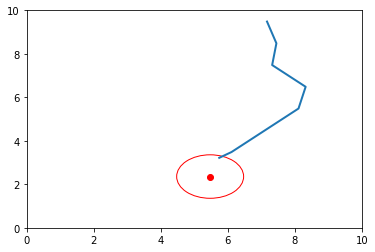

In [12]:
# test prediction
env = SimpleWalk2Dcont()
env.reset()

while True:
    action, _states = model.predict(env.state)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break
env.render()


In [13]:
evaluate_policy(model, env, n_eval_episodes=10, render=False)

/home/luttkule/anaconda3/envs/rl-test/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
DEBUG:root:movement: 1.4138890024962008
DEBUG:root:movement: 1.413608410146462
DEBUG:root:movement: 1.412687507749872
DEBUG:root:reached goal
DEBUG:root:movement: 1.3155863828300172
DEBUG:root:movement: 1.2532785532497437
DEBUG:root:movement: 1.0971234975689028
DEBUG:root:movement: 1.008185612927241
DEBUG:root:movement: 0.9853284033966465
DEBUG:root:reached goal
DEBUG:root:movement: 1.4026542867156762
DEBUG:root:reached goal
DEBUG:root:movement: 1.411290960848394
DEBUG:root:movement: 1.4082553482645657
DEBUG:root:movement: 1.395514792085469
DEBUG:root:reached goal
DEBUG:root:movement: 1.1730485968589806
DEBUG:root:mo

(1193.5016887664794, 108.21589530204028)

INFO:root:Episode:1 Score:1108.8327364307656


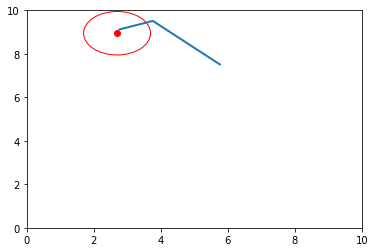

INFO:root:Episode:2 Score:1380.7145738478719


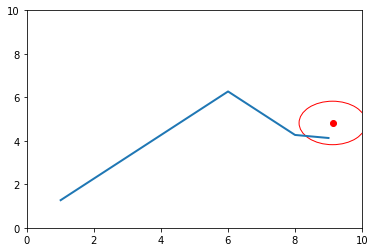

INFO:root:Episode:3 Score:953.588018012625


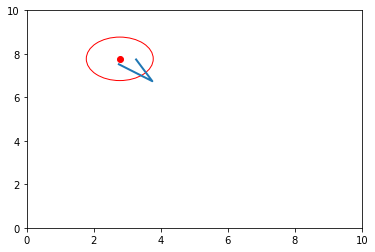

INFO:root:Episode:4 Score:1249.3483816895518


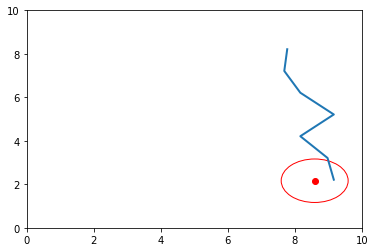

INFO:root:Episode:5 Score:1151.4709954378418


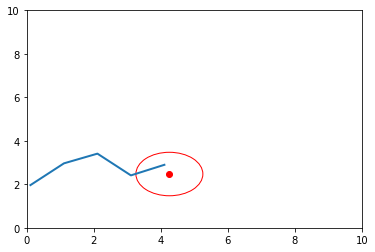

INFO:root:Episode:6 Score:1168.015441580258


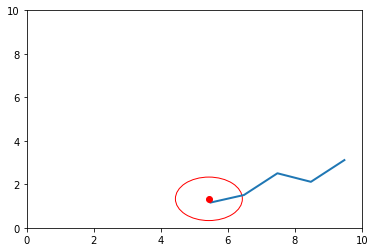

INFO:root:Episode:7 Score:1253.1673983338615


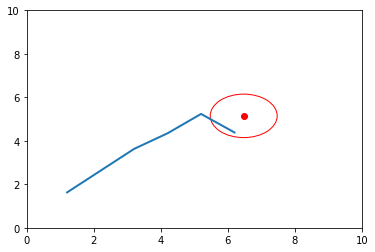

INFO:root:Episode:8 Score:1141.3734712033115


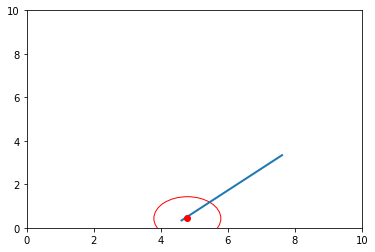

INFO:root:Episode:9 Score:1122.948579755456


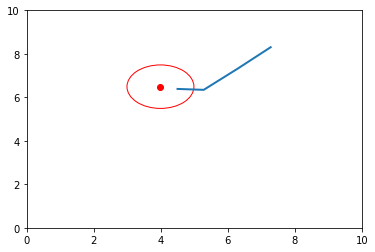

INFO:root:Episode:10 Score:1190.8839374125453


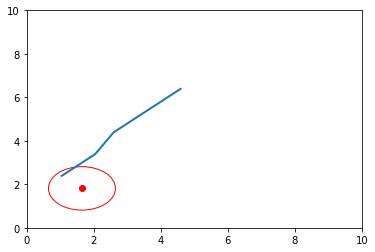

In [14]:
logger.setLevel(logging.INFO)
env = SimpleWalk2Dcont()
episodes = 10
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        # env.render()
        action, _state = model.predict(state)
        n_state, reward, done, info = env.step(action)
        logging.debug('Steps taken: {}'.format(info['steps_taken']))
        logging.debug('distance to goal: {}'.format(info['distance_to_goal']))
        score+=reward
    logging.info('Episode:{} Score:{}'.format(episode, score))
    env.render()
env.close()

## Remarks

PPO_26

training looks stable till step 80k 

training sufficient after 15k

## TODO

```shell
C:\Users\Luttk\anaconda3\envs\rl-test\lib\site-packages\stable_baselines3\common\env_checker.py:130: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(
```